# Welcome to the 3D Object Detection & Visualization Workshop!
In this notebook, you'll work with a sequence of images and point clouds, and will learn to run 3D object detection algorithms to them. We will also learn how to visualize our results in 2D and 3D environments. So let us begin.
<p>

**Note:** This notebook has been adapted for educational purpose from [this repo](https://github.com/hailanyi/3D-Detection-Tracking-Viewer), and the model is running with weights downloaded on [this repo](https://github.com/open-mmlab/OpenPCDet).

In [1]:
# !pip install numpy==1.26.3

In [2]:
# !pip install spconv-cu118 -q
# !pip install SharedArray2 -q
# !pip install ipyvtklink -q
# !pip install pyquaternion==0.9.9

In [3]:
# !pip install rerun-sdk==0.22.1

### Please restart the kernel by clicking: Run-> Restart and clear cell outputs

## 1. Imports

In [4]:
# now run
import os
import sys
sys.path.append('4d-dataset/')
sys.path.append('4d-dataset/multi_object_tracking/multi_object_tracking')
sys.path.append('4d-dataset/viewer')
sys.path.append('4d-dataset/pointrcnn/pointrcnn')
sys.path.append('4d-dataset/pointrcnn/pointrcnn/OpenPCDet')
sys.path.append('4d-dataset/pointrcnn/pointrcnn/OpenPCDet/pcdet')

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [5]:
import time
import tqdm
import logging
import argparse
from pathlib import Path
import yaml
import json
from easydict import EasyDict
from collections.abc import Sequence
from dataclasses import dataclass
from typing import Any, Final
import glob
from tqdm import tqdm
import cv2
import shutil
import requests
import re
from PIL import Image
from scipy.spatial.transform import Rotation as R
from IPython.display import FileLink, display

In [6]:
import numpy as np
import numpy.typing as npt
import torch
import rerun as rr
import matplotlib.pyplot as plt
import rerun.blueprint as rrb  
from scipy.spatial.transform import Rotation as R 

In [ ]:
# type: ignore
from dataset.kitti_data_base import velo_to_cam, read_pose, read_calib, read_image, read_velodyne, cam_to_velo
# from dataset.kitti_data_base import *  # si nécessaire
from utils import *                    # utils du viewer

In [ ]:
# type: ignore
from pcdet.ops.roiaware_pool3d import roiaware_pool3d_cuda
from pcdet.config import cfg, cfg_from_yaml_file
from pcdet.datasets import DatasetTemplate
from pcdet.utils import common_utils
from box_3d import Box3D

def project_3d_box_to_image(bbox_3d, P2):
    h, w, l, x, y, z, ry = bbox_3d
    x_corners = [ l/2,  l/2, -l/2, -l/2,  l/2,  l/2, -l/2, -l/2 ]
    y_corners = [  0,    0,    0,    0,   -h,   -h,   -h,   -h ]
    z_corners = [ w/2, -w/2, -w/2,  w/2,  w/2, -w/2, -w/2,  w/2 ]

    corners_3d = np.vstack([x_corners, y_corners, z_corners])
    R_y = np.array([
        [ np.cos(ry), 0, np.sin(ry)],
        [         0, 1,         0],
        [-np.sin(ry), 0, np.cos(ry)]
    ])
    corners_3d = R_y @ corners_3d + np.array([[x], [y], [z]])
    corners_3d_hom = np.vstack((corners_3d, np.ones((1, 8))))
    corners_2d = P2 @ corners_3d_hom
    corners_2d = corners_2d[:2] / corners_2d[2]
    return corners_2d.T

fatal: not a git repository (or any of the parent directories): .git


## 2. Data

In [9]:
class KittiDataset(DatasetTemplate):
    def __init__(self, root_path, seq_id, dataset_cfg, class_names, label_path=None):
        super().__init__(
            dataset_cfg=dataset_cfg, class_names=class_names, training=False, root_path=root_path
        )
        self.seq_name = str(seq_id).zfill(4)
        self.root_path = root_path
        self.velo_path = os.path.join(self.root_path,"velodyne", self.seq_name)
        self.image_path = os.path.join(self.root_path,"image_02", self.seq_name)
        self.calib_path = os.path.join(self.root_path,"calib")
        self.label_path = label_path
        pose_path = os.path.join(self.root_path, "pose", self.seq_name,'pose.txt')
        self.poses = read_pose(pose_path)

    def __len__(self):
        return len(os.listdir(self.velo_path))

    def __getitem__(self, item):
        input_dict = {}
        name = str(item).zfill(6)
        velo_path = os.path.join(self.velo_path,name+'.bin')
        image_path = os.path.join(self.image_path, name+'.png')
        calib_path = os.path.join(self.calib_path, self.seq_name+'.txt')

        input_dict["frame_id"] = item

        pose = self.poses[item] if item in self.poses.keys() else None;
        input_dict["pose"] = pose

        P2,V2C = read_calib(calib_path)
        input_dict["P2"] = P2
        input_dict["V2C"] = V2C

        points = read_velodyne(velo_path,P2,V2C)
        input_dict["points"] = points

        image = read_image(image_path)
        input_dict["image"] = image

        objects, objects_cam, det_scores, det_names = [], [], [], []

        if self.label_path is not None:
            # If we have a label path, we'll read the labels instead of predicting them
            label_path = os.path.join(self.label_path, self.seq_name, name+'.txt')
            objects, det_scores, det_names = self.read_detection_label(label_path)
        if len(objects)>0:
            objects_cam = np.copy(objects)
            objects[:,3:6] = cam_to_velo(objects[:,3:6],V2C)[:,:3]
        input_dict["objects"] = objects
        input_dict["objects_cam"] = objects_cam
        input_dict["scores"] = det_scores
        input_dict["names"] = det_names

        return input_dict

    def read_detection_label(self,label_path):
        objects_list = []
        det_scores = []
        det_names = []
        with open(label_path) as f:
            for each_ob in f.readlines():
                infos = re.split(' ', each_ob)
                if infos[0] in ['Car', 'Truck','Van', 'Cyclist']:
                    objects_list.append(infos[8:15])
                    det_scores.append(infos[15])
                    det_names.append(infos[0])
        return np.array(objects_list, np.float32), np.array(det_scores, np.float32), det_names

In [10]:
cfg_file = '4d-dataset/pointrcnn/pointrcnn/pointrcnn.yaml' ## this further uses kitti_dataset.yaml

In [ ]:
cfg_from_yaml_file(cfg_file, cfg)

In [12]:
cfg.CLASS_NAMES

['Car', 'Pedestrian', 'Cyclist']

In [13]:
root = "4d-dataset/data/data"
label_dir = "4d-dataset/multi_object_tracking/multi_object_tracking/detectors/point_rcnn"

dataset = KittiDataset(
    root_path=root,
    seq_id=8,
    dataset_cfg=cfg.DATA_CONFIG,
    class_names=cfg.CLASS_NAMES,
    label_path=label_dir
)

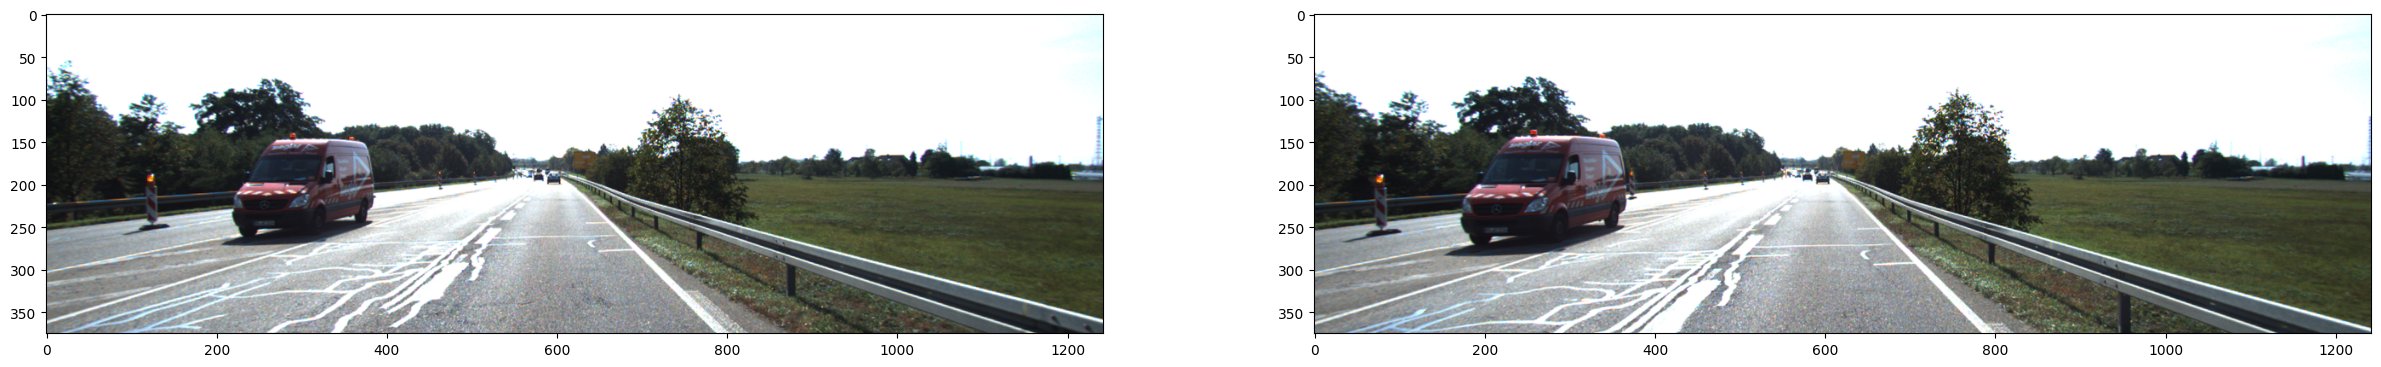

In [14]:
def view_images(images_to_be_shown):
  _, axs = plt.subplots(1, len(images_to_be_shown), figsize=(30, 30))

  if len(images_to_be_shown)> 1:
    axs = axs.flatten()
    for img, ax in zip(images_to_be_shown, axs):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  else:
      img = images_to_be_shown[0]
      axs.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

  plt.show()


hand_picked_frames = [50, 51]  # You can change this to any frame numbers you want to visualize
# hand_picked_frames = [50]  # If you want to visualize only one frame
images_2d = [dataset[i]["image"] for i in hand_picked_frames]

view_images(images_2d)

### 3. Data & Label Visualization (3D Viewer)

In [15]:
def visualize(dataset, frames=None, output_path=None,score_threshold=0.8, viz_labels=False):
    rr.init("KITTI Visualizer111 111", recording_id="new_run111 111", spawn=False)

    blueprint = rrb.Blueprint(
        rrb.Horizontal(
            rrb.Spatial2DView(origin="world/ego_vehicle/camera", name="Camera"),
            rrb.Spatial3DView(origin="world/ego_vehicle/lidar", name="LiDAR"),
            column_shares=[1, 1]
        )
    )

    rr.log("world/ego_vehicle/camera/", rr.ViewCoordinates.RIGHT_HAND_Y_DOWN)
    rr.log("world/ego_vehicle/lidar/", rr.ViewCoordinates.RIGHT_HAND_Z_UP)

    class_colors = {
        'Car': [255, 0, 0, 128],
        'Pedestrian': [0, 255, 0, 128],
        'Cyclist': [0, 0, 255, 128]
    }

    if frames is None:
        print(len(dataset))
        frames = list(range(len(dataset)))

    for i in frames:
        rr.set_time_sequence("frame", i)
        rr.log("world/ego_vehicle/camera/image/detections", rr.Clear(recursive=True))
        rr.log("world/ego_vehicle/lidar/boxes", rr.Clear(recursive=True))

        data = dataset[i]
        image = np.array(data['image'])
        points = data['points']
        P2, V2C = data['P2'], data['V2C']
        pose = data['pose']

        if pose is not None:  
            # Extract translation and rotation from pose matrix  
            translation = pose[:3, 3]  # Extract translation from 4x4 pose matrix  
            rotation_matrix = pose[:3, :3]  # Extract rotation matrix  
            # Convert rotation matrix to quaternion  
            r = R.from_matrix(rotation_matrix)  
            quat_xyzw = r.as_quat()  # scipy returns [x, y, z, w]  

            rr.log("world/ego_vehicle", rr.Transform3D(  
                translation=translation,  
                quaternion=rr.Quaternion(xyzw=quat_xyzw),  
                relation=rr.TransformRelation.ParentFromChild,  
            )) 

        rr.log("world/ego_vehicle/camera/image", rr.Image(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))

        positions = points[:, :3]
        # distances = np.linalg.norm(positions, axis=1)
        # norm = (255.0 * (distances - distances.min()) / (np.ptp(distances) + 1e-5)).astype(np.uint8)
        # colors = (plt.cm.cividis(norm / 255.0)[:, :3] * 255).astype(np.uint8)
        colors = (plt.cm.cividis(np.linspace(0, 1, len(positions)))[:, :3] * 255).astype(np.uint8)  # Use a colormap for colors
        rr.log("world/ego_vehicle/lidar/points", rr.Points3D(positions=positions, colors=colors))

        if viz_labels:
            centers, sizes, rotations, labels, box_colors = [], [], [], [], []
    
            for j, (box, box_cam, score, name) in enumerate(zip(data['objects'], data['objects_cam'], data['scores'], data['names'])):
                if score < score_threshold:
                    continue

                # 3D Camera Boxes
                corners_2d = project_3d_box_to_image(box_cam,P2)
                edges = [
                    [0, 1], [1, 2], [2, 3], [3, 0],
                    [4, 5], [5, 6], [6, 7], [7, 4],
                    [0, 4], [1, 5], [2, 6], [3, 7]
                ]
                lines = [np.array([corners_2d[start], corners_2d[end]]) for start, end in edges]
                box_colors.append(class_colors.get(name, [128, 128, 128, 128]))
    
                rr.log(f"world/ego_vehicle/camera/image/detections/box_{j}", rr.LineStrips2D(lines, labels=[f"{name} {score:.2f}"], colors=np.array(box_colors)))
                # rr.log(f"world/ego_vehicle/camera/image/detections/box_{j}/label", rr.Points2D([np.mean(corners_2d, axis=0)], colors=np.array(box_colors)))

                # 3D Lidar boxes 
                h, w, l, x, y, z, ry = box  
                # Convert KITTI rotation to Rerun coordinate system  
                yaw = -ry - np.pi / 2  
                center = np.array([x, y, z + h / 2])  
                size = np.array([l, w, h])  

                # Create quaternion for rotation around Z-axis in Rerun's coordinate system  
                quat = R.from_euler('z', yaw, degrees=False).as_quat()  
                # Rerun expects [w, x, y, z] format  
                quat = np.array([quat[0], quat[1], quat[2], quat[3]])
    
                centers.append(center)
                sizes.append(size)
                rotations.append(quat)
                labels.append(f"{name} {score:.2f}")
    
            if centers:
                rr.log("world/ego_vehicle/lidar/boxes", rr.Boxes3D(
                    centers=np.array(centers),
                    half_sizes=np.array(sizes) / 2,
                    quaternions=np.array(rotations),
                    labels=labels,
                    colors=np.array(box_colors),
                    fill_mode="solid"
                ))

    rr.save(output_path, default_blueprint=blueprint)
    print(f"Visualization saved. Run:\nrerun {output_path}")

In [ ]:
out_path = "output/data.rrd"
# visualize(dataset, output_path=out_path, frames=range(220, 270), viz_labels=False)
visualize(dataset, output_path=out_path, viz_labels=False)

### If your code breaks, the rerun will break. Make
#rr.save("output/test.rrd")

390


[2025-08-20T13:34:08Z WARN  re_sdk_comms::server] Closing connection to client at 127.0.0.1:49636: The receiving end of the channel was closed
[2025-08-20T13:34:08Z WARN  re_sdk_comms::server] Closing connection to client at 127.0.0.1:58426: The receiving end of the channel was closed
[2025-08-20T13:34:08Z WARN  re_sdk_comms::server] Closing connection to client at 127.0.0.1:58434: The receiving end of the channel was closed
[2025-08-20T13:34:08Z WARN  re_sdk_comms::server] Closing connection to client at 127.0.0.1:58436: The receiving end of the channel was closed
[2025-08-20T13:34:08Z WARN  re_sdk_comms::server] Closing connection to client at 127.0.0.1:58438: The receiving end of the channel was closed
[2025-08-20T13:34:08Z WARN  re_sdk_comms::server] Closing connection to client at 127.0.0.1:58452: The receiving end of the channel was closed
[2025-08-20T13:34:09Z WARN  re_sdk_comms::buffered_client] Failed to send message after 3 attempts: Failed to send to Rerun server at 127.0.0.

Visualization saved. Run:
rerun data.rrd


Try to visualize One Frame, then some Hand Picked Frames, then the entire video!

### Label Visualization

![img](https://thinkautonomous-3d-tracking.s3.us-west-2.amazonaws.com/download+(1)+(1).jpeg)

In [ ]:
out_path = "output/labels55.rrd"
visualize(dataset, output_path=out_path, viz_labels=True)

### If your code breaks, the rerun will break. Make
#rr.save("output/test.rrd")

390
Visualization saved. Run:
rerun labels55.rrd


In [16]:
!rerun

[2025-08-20T19:39:07Z INFO  winit::platform_impl::linux::x11::window] Guessed window scale factor: 1
[2025-08-20T19:39:07Z WARN  wgpu_hal::gles::adapter] Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
[2025-08-20T19:39:07Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-20T19:39:07Z WARN  wgpu_hal::gles::adapter] Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
[2025-08-20T19:39:07Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-20T19:39:07Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-20T19:39:07Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-20T19:39:07Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-20T19:39:07Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000


## Part 2: 3D Object Detection
Later in the course, we'll work with Object Trackers. There are 2 types of trackers:
1.   **Separate Trackers**
2.   **Joint Trackers**

The first type first detect objects and then track them (using algorithms we explore in the course). The second type directly outputs tracking based on a sequence (2 images or files sent to a neural network, a tracking input).

In this notebook, we'll use the **first type**. And therefore our first task will be to detect the objects.
<p>

In this notebook, we'll focus on tracking and therefore run this as black box. You'll still be able to understand how this works, play with the point clouds, inputs and outputs. If you'd like more details on the inside of this architecture, I refer you to my course [DEEP POINT CLOUDS](https://courses.thinkautonomous.ai/deep-point-clouds).
<p>

![](https://raw.githubusercontent.com/sshaoshuai/PointRCNN/master/doc/teaser.png)

#### PointRCNN
We'll use the library OpenPCDet, which will implement the PointRCNN algorithm based on [this repo](https://github.com/open-mmlab/OpenPCDet).<p>

In [18]:
from pcdet.models import build_network, load_data_to_gpu

In [19]:
import argparse
import glob
from pathlib import Path
import torch

In [20]:
from box_3d import Box3D

In [21]:
model_ckpt = '4d-dataset/pointrcnn/pointrcnn/pointrcnn_7870.pth'
output_file_dir = f'3d_object_detection_results/0008'
id_to_name = {1: 'Car', 2: 'Pedestrian', 3: 'Cyclist', 4: 'Van'}

In [22]:
print(cfg.CLASS_NAMES)

['Car', 'Pedestrian', 'Cyclist']


In [23]:
logger = common_utils.create_logger()
logger.info(f"CLASS_NAMES: {cfg.CLASS_NAMES}")

2025-08-20 15:30:21,455   INFO  CLASS_NAMES: ['Car', 'Pedestrian', 'Cyclist']


In [24]:
model = build_network(model_cfg=cfg.MODEL, num_class=len(cfg.CLASS_NAMES), dataset=dataset)
model.load_params_from_file(filename=model_ckpt,logger=logger, to_cpu=True)
model.cuda()

2025-08-20 15:30:22,066   INFO  ==> Loading parameters from checkpoint 4d-dataset/pointrcnn/pointrcnn/pointrcnn_7870.pth to CPU
2025-08-20 15:30:22,119   INFO  ==> Done (loaded 309/309)


PointRCNN(
  (vfe): None
  (backbone_3d): PointNet2MSG(
    (SA_modules): ModuleList(
      (0): PointnetSAModuleMSG(
        (groupers): ModuleList(
          (0-1): 2 x QueryAndGroup()
        )
        (mlps): ModuleList(
          (0): Sequential(
            (0): Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (5): ReLU()
            (6): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (8): ReLU()
          )
          (1): Sequential(
            (0): Conv2d(4, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(32,

In [25]:
!mkdir -p '3d_object_detection_results/0008'

In [26]:
def limit_period(val, offset=0.5, period=np.pi):
    """Limit the value into a period for periodic function.
    Args:
        val (torch.Tensor | np.ndarray): The value to be converted.
        offset (float, optional): Offset to set the value range.
            Defaults to 0.5.
        period ([type], optional): Period of the value. Defaults to np.pi.
    Returns:
        (torch.Tensor | np.ndarray): Value in the range of
            [-offset * period, (1-offset) * period]
    """
    limited_val = val - np.floor(val / period + offset) * period
    return limited_val

In [27]:
print(len(dataset))

390


In [28]:
hand_picked_frames = range(75)
print(len(hand_picked_frames))

75


# perception
# localization
# planning
# control

the outut of perception is:

* all the object
* their IDs
* 3D bounding boxes (3D positions)
* their velocities
* their trajectories (past and future)

In [ ]:
model.eval()
with torch.no_grad():
    for i in hand_picked_frames:
        inference_result = []
        #read data
        data_dict = {k: dataset[i][k] for k in ["points","frame_id"] if k in dataset[i]}
        data_dict = dataset.collate_batch([data_dict])
        load_data_to_gpu(data_dict)

        # Forward propagation

        pred_dicts, _ = model.forward(data_dict)

        points = data_dict['points']#[:, :3]
        bboxes = pred_dicts[0]['pred_boxes'].cpu().detach().numpy()
        scores = pred_dicts[0]['pred_scores'].cpu().detach().numpy()
        labels = pred_dicts[0]['pred_labels'].cpu().detach().numpy()
        P2 = np.column_stack((dataset[i]["P2"].T, [0,0,1,0]))

        # Postprocess
        inference_result.append([])
        for bbox, score, label in zip(bboxes, scores, labels):
            pos = bbox[:3]  # x, y, z
            dim = bbox[[4, 5, 3]]   # w, h, l
            yaw = bbox[-1]
            yaw = -yaw - np.pi / 2
            yaw = limit_period(yaw, period=np.pi * 2)
            label_name = id_to_name[label]
            box3d = Box3D(pos, dim, yaw, label_name, score, dataset[i]["V2C"].T, P2)
            inference_result[-1].append(box3d)

        # Write to file
        output_file_name = output_file_dir + '/' + str(i).zfill(6) + '.txt'
        f = open(output_file_name, 'w+')
        for each_3d_box in inference_result[0]:
            f.write(each_3d_box.to_kitti_format(each_3d_box.confidence))
            f.write('\n')
        f.close()

In [29]:
print(bboxes)
print(scores)
print(labels)

[[ 7.4821625e+01  1.5641755e+00 -6.4537233e-01  3.9507902e+00
   1.6335970e+00  1.5247622e+00 -5.0488401e-02]
 [ 4.7591000e+01  2.9087767e+01  5.3445899e-01  4.0322824e+00
   1.6596485e+00  1.5547514e+00  2.6530888e+00]]
[0.15314808 0.14366707]
[1 1]


In [ ]:
label_path = "3d_object_detection_results"
output_path = "output/pointrcnn.rrd"

dataset = KittiDataset(root, seq_id=8, label_path=label_path, dataset_cfg=cfg.DATA_CONFIG, class_names=cfg.CLASS_NAMES)

visualize(dataset, output_path=output_path, frames=hand_picked_frames, viz_labels=True)

[2025-08-20T13:31:18Z INFO  winit::platform_impl::linux::x11::window] Guessed window scale factor: 1
[2025-08-20T13:31:19Z WARN  wgpu_hal::gles::adapter] Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
[2025-08-20T13:31:19Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-20T13:31:19Z WARN  wgpu_hal::gles::adapter] Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
[2025-08-20T13:31:19Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-20T13:31:19Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-20T13:31:19Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-20T13:31:20Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-20T13:31:20Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000


Visualization saved. Run:
rerun pointrcnn.rrd


[2025-08-20T13:31:37Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-20T13:31:37Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-20T13:31:37Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-20T13:31:37Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000


### 3.2. Try other models

In [31]:
sys.path.append('4d-dataset-second/')

In [32]:
#cfg_file = '4d-perception-second/second.yaml'
cfg_file = '4d-dataset-second/PartA2_free.yaml'
cfg_from_yaml_file(cfg_file, cfg)

logger = common_utils.create_logger()

# 3. Crée le dataset sans rien changer
from pcdet.datasets import build_dataloader
# dataset, dataloader, _ = build_dataloader(
#     dataset_cfg=cfg.DATA_CONFIG,
#     class_names=cfg.CLASS_NAMES,
#     batch_size=1,
#     dist=False,
#     workers=0,
#     logger=logger,
#     training=False
# )

model_ckpt = '4d-dataset-second/PartA2_free_7872.pth'

from pcdet.models import build_network
model = build_network(model_cfg=cfg.MODEL, num_class=len(cfg.CLASS_NAMES), dataset=dataset)
model.load_params_from_file(filename=model_ckpt, logger=logger, to_cpu=False)
model.cuda()
model.eval()

print("************************")
print(dataset)
print("************************")
data_dict = dataset[0]
# from pcdet.datasets.collate_utils import collate_batch
# from pcdet.utils.common_utils import move_data_to_device
 
batch = dataset.collate_batch([data_dict])
load_data_to_gpu(batch)
preds, _ = model(batch)

TypeError: 'NoneType' object is not subscriptable

## Visualize Tracking

In [20]:
from dataset.kitti_data_base import read_tracking_label

In [ ]:
def visualize_tracking(dataset, tracking_label_path, frames=None, output_path=None, score_threshold=0.8):  
    rr.init("KITTI Visualizer 74584", recording_id=None, spawn=True)  

    blueprint = rrb.Blueprint(
        rrb.Horizontal(
            rrb.Spatial2DView(origin="world/ego_vehicle/camera", name="Camera"),
            rrb.Spatial3DView(origin="world/ego_vehicle/lidar", name="LiDAR"),
            column_shares=[1, 1]
        )
    )

    rr.log("world/ego_vehicle/camera/", rr.ViewCoordinates.RIGHT_HAND_Y_DOWN)
    rr.log("world/ego_vehicle/lidar/", rr.ViewCoordinates.RIGHT_HAND_Z_UP)
      
    # Load tracking data  
    tracking_frame_dict, tracking_names_dict = read_tracking_label(tracking_label_path)  
      
    if frames is None:  
        frames = list(range(len(dataset)))  
      
    # Store trajectories for visualization  
    trajectories = {}  # track_id -> list of center_3d positions  
      
    for i in frames:  
        rr.set_time_sequence("frame", i)  
        rr.log("world/ego_vehicle/camera/image/detections", rr.Clear(recursive=True))
        rr.log("world/ego_vehicle/lidar/boxes", rr.Clear(recursive=True))  
        # rr.log("world/ego_vehicle/lidar/trajectories", rr.Clear(recursive=True))  
          
        data = dataset[i]
        image = np.array(data['image'])
        points = data['points']  
        pose = data['pose']  
  
        if pose is not None:  
            # Extract translation and rotation from pose matrix  
            translation = pose[:3, 3]  # Extract translation from 4x4 pose matrix  
            rotation_matrix = pose[:3, :3]  # Extract rotation matrix  
            # Convert rotation matrix to quaternion  
            r = R.from_matrix(rotation_matrix)  
            quat_xyzw = r.as_quat()  # scipy returns [x, y, z, w]  
              
            rr.log("world/ego_vehicle", rr.Transform3D(  
                translation=translation,  
                quaternion=rr.Quaternion(xyzw=quat_xyzw),  
                relation=rr.TransformRelation.ParentFromChild,  
            ))
        
        rr.log("world/ego_vehicle/camera/image", rr.Image(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))
          
        # Log point cloud with distance-based coloring  
        positions = points[:, :3]   
        colors = (plt.cm.cividis(np.linspace(0, 1, len(positions)))[:, :3] * 255).astype(np.uint8)  # Use a colormap for colors
        rr.log("world/ego_vehicle/lidar/points", rr.Points3D(positions=positions, colors=colors))  
          
        if i not in tracking_frame_dict:  
            continue  

        track_data = tracking_frame_dict[i]  
        track_names = tracking_names_dict[i]  

        centers, sizes, rotations, labels, colors = [], [], [], [], []  

        for i, (entry, name) in enumerate(zip(track_data, track_names)):  
            h, w, l, x, y, z, ry, track_id = entry

            box_cam = np.array([h, w, l, x, y, z, ry])
            # 3D Camera Boxes
            corners_2d = project_3d_box_to_image(box_cam, data['P2'])
            edges = [
                [0, 1], [1, 2], [2, 3], [3, 0],
                [4, 5], [5, 6], [6, 7], [7, 4],
                [0, 4], [1, 5], [2, 6], [3, 7]
            ]
            lines = [np.array([corners_2d[start], corners_2d[end]]) for start, end in edges]

            if l * w * h == 0:  # Skip invalid boxes  
                continue  

            # KITTI coordinate system: X=right, Y=down, Z=forward  
            # Rerun RIGHT_HAND_Z_UP: X=right, Y=forward, Z=up  
            center = np.array([z, -x, -y + h / 2])  # Transform KITTI to Rerun coordinates  
            size = np.array([l, w, h])    
              
            # Fix rotation: Ensure boxes are horizontal and properly oriented  
            # For horizontal boxes in the XY plane, we need to adjust the rotation  
            yaw = -ry + np.pi / 2  # Adjust rotation to keep boxes horizontal  
            quat = R.from_euler('z', yaw, degrees=False).as_quat()  
            quat_rerun = np.array([quat[3], quat[0], quat[1], quat[2]])  # [w,x,y,z]  
              
            # Generate unique color per track ID  
            color = np.array([  
                (37 * track_id) % 255,  
                (17 * track_id) % 255,  
                (91 * track_id) % 255,  
                255  
            ]).astype(np.uint8)  
              
            centers.append(center)  
            sizes.append(size)  
            rotations.append(quat_rerun)  
            labels.append(f"ID {int(track_id)}")  
            colors.append(color)  

            rr.log(f"world/ego_vehicle/camera/image/detections/box_{i}", 
                   rr.LineStrips2D(lines, labels=[f"ID {track_id}"], colors=np.array(color)))
              
            # Store trajectory data with corrected coordinates  
            if track_id not in trajectories:  
                trajectories[track_id] = []  
            trajectories[track_id].append(center.copy())  
          
        # Log 3D boxes  
        if centers:  
            rr.log("world/ego_vehicle/lidar/boxes", rr.Boxes3D(  
                centers=np.array(centers),  
                half_sizes=np.array(sizes) / 2,  
                quaternions=np.array(rotations),  
                labels=labels,  
                colors=np.array(colors),  
                fill_mode="solid"  
            ))  

        # Log trajectories with unique colors per track  
        for track_id, trajectory in trajectories.items():  
            if len(trajectory) > 1:  
                # Only show trajectory up to current frame  
                # current_frame_trajectory = trajectory[:len([f for f in frames if f <= i])]  
                current_frame_trajectory = trajectory[:i + 1]  
                if len(current_frame_trajectory) > 1:  
                    trajectory_points = np.array(current_frame_trajectory)  
                      
                    # Generate the same unique color for this track ID as used for boxes  
                    trajectory_color = np.array([  
                        (37 * track_id) % 255,  
                        (17 * track_id) % 255,  
                        (91 * track_id) % 255,  
                        180  # Alpha for transparency  
                    ]).astype(np.uint8)  
                      
                    # Create trajectory line with unique color  
                    rr.log(  
                        f"world/ego_vehicle/lidar/trajectories/track_{track_id}",  
                        rr.LineStrips3D([trajectory_points], colors=[trajectory_color])  
                    )  
                      
                    # Mark trajectory points with the same color  
                    rr.log(  
                        f"world/ego_vehicle/lidar/trajectories/track_{track_id}/points",  
                        rr.Points3D(trajectory_points, colors=[trajectory_color], radii=[0.1])  
                    )  

    rr.save(output_path, default_blueprint=blueprint)  
    print(f"Tracking visualization saved. Run:\nrerun {output_path}")

In [ ]:
#  Add the tracking path
# preds_path = "3d_object_detection_results"
# label_path = "3d_object_detection_results"
# label_path = "4d-dataset/0008"
output_path = "output/predictions_video_sequence.rrd"

# dataset = KittiDataset(root, seq_id=8, label_path=label_path, dataset_cfg=cfg.DATA_CONFIG, class_names=cfg.CLASS_NAMES)

print(len(dataset))
tracking_path = "4d-dataset/0008/0008.txt"
visualize_tracking(  
    dataset=dataset,  
    tracking_label_path=tracking_path,  
    frames=range(len(dataset)),  
    output_path=output_path,  
    score_threshold=0.8  
)

390


[2025-08-21T00:11:56Z INFO  winit::platform_impl::linux::x11::window] Guessed window scale factor: 1
[2025-08-21T00:11:56Z WARN  wgpu_hal::gles::adapter] Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
[2025-08-21T00:11:56Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-21T00:11:56Z WARN  wgpu_hal::gles::adapter] Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
[2025-08-21T00:11:56Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-21T00:11:56Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-21T00:11:56Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-21T00:11:57Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-21T00:11:57Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-21T00:12:28Z WARN  wgpu_hal::vulkan::con

Tracking visualization saved. Run:
rerun predictions_video_sequence.rrd


In [26]:
def visualizeeeeeeeeee(dataset, tracking_label_path, frames=None, output_path=None,score_threshold=0.8):
    rr.init("KITTI Visualizer", recording_id="87544", spawn=True)

    # blueprint = rrb.Blueprint(  
    #     rrb.Spatial3DView(origin="world/ego_vehicle/lidar", name="LiDAR Tracking")  
    # ) 

    blueprint = rrb.Blueprint(
        rrb.Horizontal(
            rrb.Spatial2DView(origin="world/ego_vehicle/camera", name="Camera"),
            rrb.Spatial3DView(origin="world/ego_vehicle/lidar", name="LiDAR"),
            column_shares=[1, 1]
        )
    )

    rr.log("world/ego_vehicle/camera/", rr.ViewCoordinates.RIGHT_HAND_Y_DOWN)
    rr.log("world/ego_vehicle/lidar/", rr.ViewCoordinates.RIGHT_HAND_Z_UP)

    # Load tracking data
    tracking_frame_dict, tracking_names_dict = read_tracking_label(tracking_label_path)

    if frames is None:
        frames = list(range(len(dataset)))

    # Store trajectories for visualization  
    trajectories = {}  # track_id -> list of center_3d positions  

    for i in frames:
        rr.set_time_sequence("frame", i)
        # rr.log("world/ego_vehicle/camera/image/detections", rr.Clear(recursive=True))
        rr.log("world/ego_vehicle/lidar/boxes", rr.Clear(recursive=True))
        rr.log("world/ego_vehicle/lidar/trajectories", rr.Clear(recursive=True))  

        data = dataset[i]
        image = np.array(data['image'])
        points = data['points']
        # P2, V2C = data['P2'], data['V2C']
        pose = data['pose']

        if pose is not None:  
            # Extract translation and rotation from pose matrix  
            translation = pose[:3, 3]  # Extract translation from 4x4 pose matrix  
            rotation_matrix = pose[:3, :3]  # Extract rotation matrix  
            # Convert rotation matrix to quaternion  
            r = R.from_matrix(rotation_matrix)  
            quat_xyzw = r.as_quat()  # scipy returns [x, y, z, w]  

            rr.log("world/ego_vehicle", rr.Transform3D(  
                translation=translation,  
                quaternion=rr.Quaternion(xyzw=quat_xyzw),  
                relation=rr.TransformRelation.ParentFromChild,  
            )) 

        rr.log("world/ego_vehicle/camera/image", rr.Image(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))

        positions = points[:, :3]
        colors = (plt.cm.cividis(np.linspace(0, 1, len(positions)))[:, :3] * 255).astype(np.uint8)  # Use a colormap for colors
        rr.log("world/ego_vehicle/lidar/points", rr.Points3D(positions=positions, colors=colors))

        if i not in tracking_frame_dict:  
            continue  

        track_data = tracking_frame_dict[i]  
        track_names = tracking_names_dict[i]  

        centers, sizes, rotations, labels, colors = [], [], [], [], [] 

        for entry, name in zip(track_data, track_names):  
            h, w, l, x, y, z, ry, track_id = entry  

            if l * w * h == 0:  # Skip invalid boxes  
                continue  

            # KITTI coordinate system: X=right, Y=down, Z=forward  
            # Rerun RIGHT_HAND_Z_UP: X=right, Y=forward, Z=up  
            center = np.array([z, -x, -y + h / 2])  # Transform KITTI to Rerun coordinates  
            size = np.array([l, w, h])    
              
            # Fix rotation: Ensure boxes are horizontal and properly oriented  
            # For horizontal boxes in the XY plane, we need to adjust the rotation  
            yaw = -ry + np.pi / 2  # Adjust rotation to keep boxes horizontal  
            quat = R.from_euler('z', yaw, degrees=False).as_quat()  
            quat_rerun = np.array([quat[3], quat[0], quat[1], quat[2]])  # [w,x,y,z]  

            color = np.array([  
                (37 * track_id) % 255,  
                (17 * track_id) % 255,  
                (91 * track_id) % 255,  
                255  
            ]).astype(np.uint8)  
              
            centers.append(center)  
            sizes.append(size)  
            rotations.append(quat_rerun)  
            labels.append(f"ID {int(track_id)}")  
            colors.append(color)  

            # Store trajectory data with corrected coordinates  
            if track_id not in trajectories:  
                trajectories[track_id] = []  
            trajectories[track_id].append(center.copy())  
          

        if centers:
            rr.log("world/ego_vehicle/lidar/boxes", rr.Boxes3D(
                centers=np.array(centers),
                half_sizes=np.array(sizes) / 2,
                quaternions=np.array(rotations),
                labels=labels,
                colors=np.array(colors),
                fill_mode="solid"
            ))
            
        # Log trajectories with unique colors per track  
        for track_id, trajectory in trajectories.items():  
            if len(trajectory) > 1:  
                # Only show trajectory up to current frame  
                # current_frame_trajectory = trajectory[:len([f for f in frames if f <= i])]  
                current_frame_trajectory = trajectory[:i + 1]  
                if len(current_frame_trajectory) > 1:  
                    trajectory_points = np.array(current_frame_trajectory)  
                      
                    # Generate the same unique color for this track ID as used for boxes  
                    trajectory_color = np.array([  
                        (37 * track_id) % 255,  
                        (17 * track_id) % 255,  
                        (91 * track_id) % 255,  
                        180  # Alpha for transparency  
                    ]).astype(np.uint8)  
                      
                    # Create trajectory line with unique color  
                    rr.log(  
                        f"world/ego_vehicle/lidar/trajectories/track_{track_id}",  
                        rr.LineStrips3D([trajectory_points], colors=[trajectory_color])  
                    )  
                      
                    # Mark trajectory points with the same color  
                    rr.log(  
                        f"world/ego_vehicle/lidar/trajectories/track_{track_id}/points",  
                        rr.Points3D(trajectory_points, colors=[trajectory_color], radii=[0.1])  
                    ) 

    rr.save(output_path, default_blueprint=blueprint)
    print(f"Visualization saved. Run:\nrerun {output_path}")

visualizeeeeeeeeee(  
    dataset=dataset,  
    tracking_label_path=tracking_path,  
    frames=range(len(dataset)),  
    output_path=output_path,  
    score_threshold=0.8  
)

[2025-08-08T15:37:53Z INFO  winit::platform_impl::linux::x11::window] Guessed window scale factor: 1
[2025-08-08T15:37:53Z WARN  wgpu_hal::gles::adapter] Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
[2025-08-08T15:37:53Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-08T15:37:53Z WARN  wgpu_hal::gles::adapter] Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
[2025-08-08T15:37:53Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-08T15:37:53Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-08T15:37:53Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-08T15:37:53Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-08T15:37:53Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-08T15:38:11Z WARN  re_sdk_comms::server]

Visualization saved. Run:
rerun predictions_video_sequence.rrd


[2025-08-08T15:38:24Z WARN  re_sdk_comms::tcp_client] Tried to flush while TCP stream was still Pending. Data was possibly dropped.
